In [1]:
import polars as pl
import pandas as pd
import numpy as np
from enum import Enum
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Input,  TimeDistributed, concatenate
from keras import regularizers, optimizers
from keras.utils import plot_model
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf



#Data manipulation

#This test using this data collumns
columns_to_normalize = ["close", "ema5", "ema20" , "macd520"]

#reading the data that already shuffled and arranged
def read_data(train_file = 'train_data.csv', val_file = 'val_data.csv', test_file = 'test_data.csv'):
    train_data = pl.read_csv(train_file)
    val_data = pl.read_csv(val_file)
    test_data = pl.read_csv(test_file)
    return train_data, val_data, test_data

#get data of x and y and return x and y, slice y
def extract_y(data):
    y = data['next_5_min']
    x = data.drop('next_5_min')
    return x,y


#we should not use min max scale cause the max changing over the time.
#we need to deal with two kinds of things : 1. train data - we need to create a scaler and fit it to the train, and then create a normalized data , 2. test/validation data - we should get as input the scaler of the train, and do normalize by him
def min_max_scaler(data):
    scaler = preprocessing.MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

#This scaler do the scaling as gaussian scaler
def z_score_normalize(data):
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler
    

def normalized_x_y(x: pl.DataFrame, y: pl.DataFrame, columns_to_normalize: list):
    # Convert Polars DataFrame to NumPy array for normalization
    x_values = x.select(columns_to_normalize).to_numpy()
    y_values = y.to_numpy().reshape(-1, 1)
    # Normalize
    normalized_x_values, scaler_x = z_score_normalize(x_values)
    normalized_y_values, scaler_y = z_score_normalize(y_values)
    # Convert back to Polars DataFrame
    normalized_x = pl.DataFrame(normalized_x_values, schema=columns_to_normalize)
    normalized_y = pl.DataFrame(normalized_y_values, schema=['normalized_y'])

    return normalized_x, normalized_y, scaler_x, scaler_y

In [2]:
train_data, val_data, test_data = read_data()
x_train, y_train = extract_y(train_data)
x_val, y_val = extract_y(val_data)
x_test, y_test = extract_y(test_data)


In [3]:
# Split data to train val and test and normalize the data
x_train, y_train, x_train_scaler, y_train_scaler = normalized_x_y(x_train, y_train, columns_to_normalize)
x_val, y_val, x_val_scaler, y_val_scaler = normalized_x_y(x_val, y_val, columns_to_normalize)
x_test, y_test, x_test_scaler, y_test_scaler = normalized_x_y(x_test, y_test, columns_to_normalize)
print(x_test[:3])
print(y_test[:3])

shape: (3, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ close     ┆ ema5      ┆ ema20     ┆ macd520   │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.781022 ┆ -0.780106 ┆ -0.779407 ┆ -0.274536 │
│ -0.779862 ┆ -0.780807 ┆ -0.780042 ┆ -0.297566 │
│ -0.78201  ┆ -0.782142 ┆ -0.780891 ┆ -0.467761 │
└───────────┴───────────┴───────────┴───────────┘
shape: (3, 1)
┌──────────────┐
│ normalized_y │
│ ---          │
│ f64          │
╞══════════════╡
│ -0.779856    │
│ -0.782004    │
│ -0.778978    │
└──────────────┘


In [4]:
# all this block will preapre the data as the needed size for the lstm model
def prepare_lstm_data(x, y, history_points, day_size):
    x_sequences = create_sequences(x, history_points, day_size)
    y_sequences = create_target_sequences(y, history_points, day_size)
    return x_sequences, y_sequences

def create_sequences(data, history_points, day_size):
    sequences = []
    
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate sequences within the current day
        for i in range(day_start, day_end - history_points + 1):
            sequences.append(data[i:i + history_points])
    
    return np.array(sequences)

#creating y data
def create_target_sequences(data, history_points, day_size):
    target_sequences = []
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate target sequences within the current day
        for i in range(day_start+history_points-1, day_end ):
            target_sequences.append(data[i])  # Get the y of the last element in the sequence(the y of the 10 number)
    return np.array(target_sequences).reshape(-1, 1)  # Reshape to (batch_size, 1, 1)




In [5]:


#Generic function that allow to create model with multiplie optione (regulations,dropout, batch sizes)
def model_creator(lstm_layer1_size, 
                  lstm_layer2_size=None, 
                  regular_layer1_size=None, 
                  regular_layer2_size=None,
                  L1=0, L2=0, 
                  dropout=0, 
                  history_points=10, 
                  x_train=None, y_train=None,
                  x_val=None, y_val=None,
                  batch_size=512, 
                  learning_rate=0.0005, 
                  epochs=50):
    # Building the model
    model = Sequential()

    # Adding first LSTM layer with optional regularization and dropout
    if L1:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)), 
                       kernel_regularizer=regularizers.l1(L1), activation="relu"))
    elif L2:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)), 
                       kernel_regularizer=regularizers.l2(L2), activation="relu"))
    else:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)), activation="relu"))
    
    if dropout:
        model.add(Dropout(dropout))

    # Adding second LSTM layer if reuired too
    if lstm_layer2_size:
        if L1:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l1(L1), activation="relu", return_sequences=False))
        elif L2:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l2(L2), activation="relu", return_sequences=False))
        else:
            model.add(LSTM(lstm_layer2_size, activation="relu", return_sequences=False))
        
        if dropout:
            model.add(Dropout(dropout))
    
    # Adding first regular Dense layer if reuired too
    if regular_layer1_size:
        if L1:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer1_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Adding second regular Dense layer if reuired too
    if regular_layer2_size:
        if L1:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer2_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Final output layer
    model.add(Dense(1, activation="linear"))

    #Our problem is Regression(we predict continuously val) and Accuracy suits for classification problems and for our one
    # Compile the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss="mse", metrics=[MeanAbsoluteError(),MeanAbsolutePercentageError()])

    # Training the model with train data and already
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Get validation predictions
    y_val_predicted = model.predict(x_val)
    
    # Extract metrics
    loss = history.history['loss']
    mae = history.history['mean_absolute_error']
    mape_values = history.history['mean_absolute_percentage_error']
    success_ratio = [100 - mape for mape in mape_values]
    val_loss = history.history.get('val_loss')
    val_mae = history.history.get('val_mean_absolute_error')
    val_mape_values = history.history['val_mean_absolute_percentage_error']
    val_success_ratio = [100 - mape for mape in val_mape_values]

    return y_val_predicted, loss, val_loss, mae, val_mae,success_ratio,val_success_ratio


In [6]:
def find_intersections(x, y1, y2):
    intersections = []
    for i in range(1, len(x)):
        if (y1[i-1] - y2[i-1]) * (y1[i] - y2[i]) < 0:
            # Calculate intersection point using linear interpolation
            x1, x2 = x[i-1], x[i]
            y1_1, y1_2 = y1[i-1], y1[i]
            y2_1, y2_2 = y2[i-1], y2[i]
            
            x_inter = x1 + (y2_1 - y1_1) * (x2 - x1) / (y1_2 - y1_1 - (y2_2 - y2_1))
            y_inter = y1_1 + (x_inter - x1) * (y1_2 - y1_1) / (x2 - x1)
            intersections.append((x_inter, y_inter))
    return intersections

def plot_errors(loss_train, loss_val, mae_train, mae_val, succees_ratio_train,success_ratio_val, title_prefix='Model Performance'):
    epochs = np.arange(len(loss_train))  # Assuming epochs are sequential indices

    # Calculate intersections
    loss_intersections = find_intersections(epochs, loss_train, loss_val)
    mae_intersections = find_intersections(epochs, mae_train, mae_val)
    
    plt.figure(figsize=(21, 6))
    plt.subplot(1, 3, 1)
    plt.plot(succees_ratio_train, label='Training success_ratio', color='blue')
    plt.plot(success_ratio_val, label='Validation success_ratio', color='orange')
    plt.title(f'{title_prefix} - success_ratio(Our custom score)')
    plt.xlabel('Epochs')
    plt.ylabel('SUCCESS RATIO %')
    plt.legend()
    plt.grid(True)



    # Plot Loss
    plt.subplot(1, 3, 2)
    plt.plot(loss_train, label='Training loss', color='blue')
    plt.plot(loss_val, label='Validation loss', color='orange')
    plt.title(f'{title_prefix} - LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('LOSS')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for LOSS
    for x_inter, y_inter in loss_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    # Plot MAE
    plt.subplot(1, 3, 3)
    plt.plot(mae_train, label='Training MAE', color='green')
    plt.plot(mae_val, label='Validation MAE', color='red')
    plt.title(f'{title_prefix} - Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for MAE
    for x_inter, y_inter in mae_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()

def plot_stock_price_result(y, y_predicted):
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot y_val_predicted
    plt.plot(y_predicted, color='blue', label='y_val_predicted')

    # Plot feature from x_val_prepared
    plt.plot(y, color='red', label='y_val')

    # Add labels and legend
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Stock price predicted vs real')
    plt.legend()

    # Show plot
    plt.show()

In [7]:
#prepare your data to LSTM model
#Data should be recieved as 3d array ,array of 2d arrays ,where each 2d array is the previous data to the model before predicting the future 
day_size=75
history_points = 10
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )


x_train is (92100, 4)
y_train is (92100, 1)
x_train_prepared is (81048, 10, 4)
y_train_prepared is (81048, 1)


In [8]:
#model based on the other notebook of https://www.kaggle.com/code/alirezanematolahy/tehran-stock-prediction-using-lstm-model#The-Dataset 
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=None, 
    regular_layer1_size=64, 
    regular_layer2_size=None,
    L1=0, 
    L2=0.0002, 
    dropout=0.2, 
    history_points=10, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.0005, 
    epochs=50
)




C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 77s 152ms/step - loss: 0.4642 - mean_absolute_error: 0.4123 - mean_absolute_percentage_error: 95.0070 - val_loss: 0.0158 - val_mean_absolute_error: 0.0503 - val_mean_absolute_percentage_error: 45.3919
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0472 - mean_absolute_error: 0.1262 - mean_absolute_percentage_error: 88.3123 - val_loss: 0.0134 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 56.4397
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.0380 - mean_absolute_error: 0.1099 - mean_absolute_percentage_error: 57.8175 - val_loss: 0.0137 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 31.3377
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - loss: 0.0320 - mean_absolute_error: 0.0986 - mean_absolute_percentage_error: 85.0496 - val_loss: 0.0149 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 18.4494
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━

In [9]:
y_val_predicted = y_val_scaler.inverse_transform(y_val_predicted)
y_val_prepared = y_val_scaler.inverse_transform(y_val_prepared)

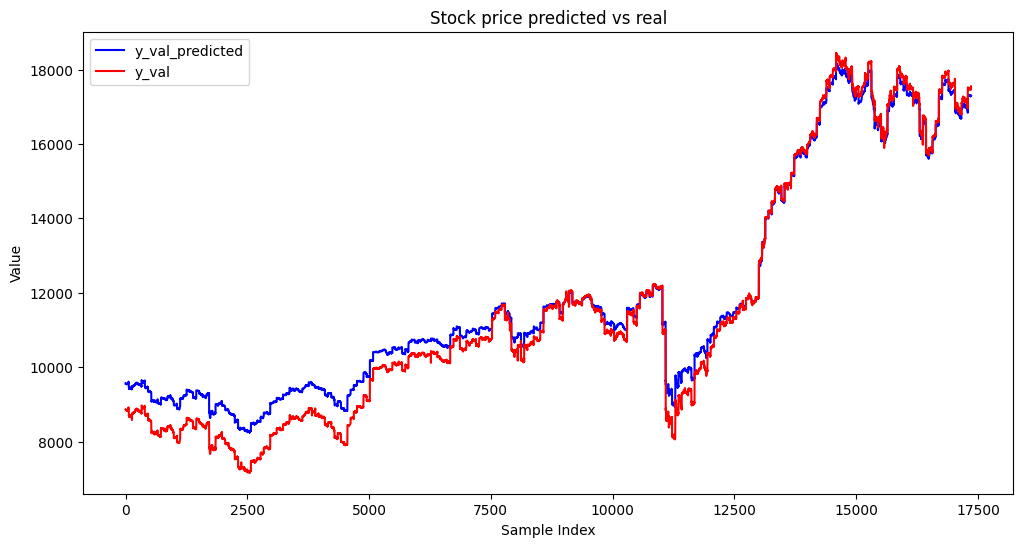

In [10]:
plot_stock_price_result(y_val_prepared,y_val_predicted)

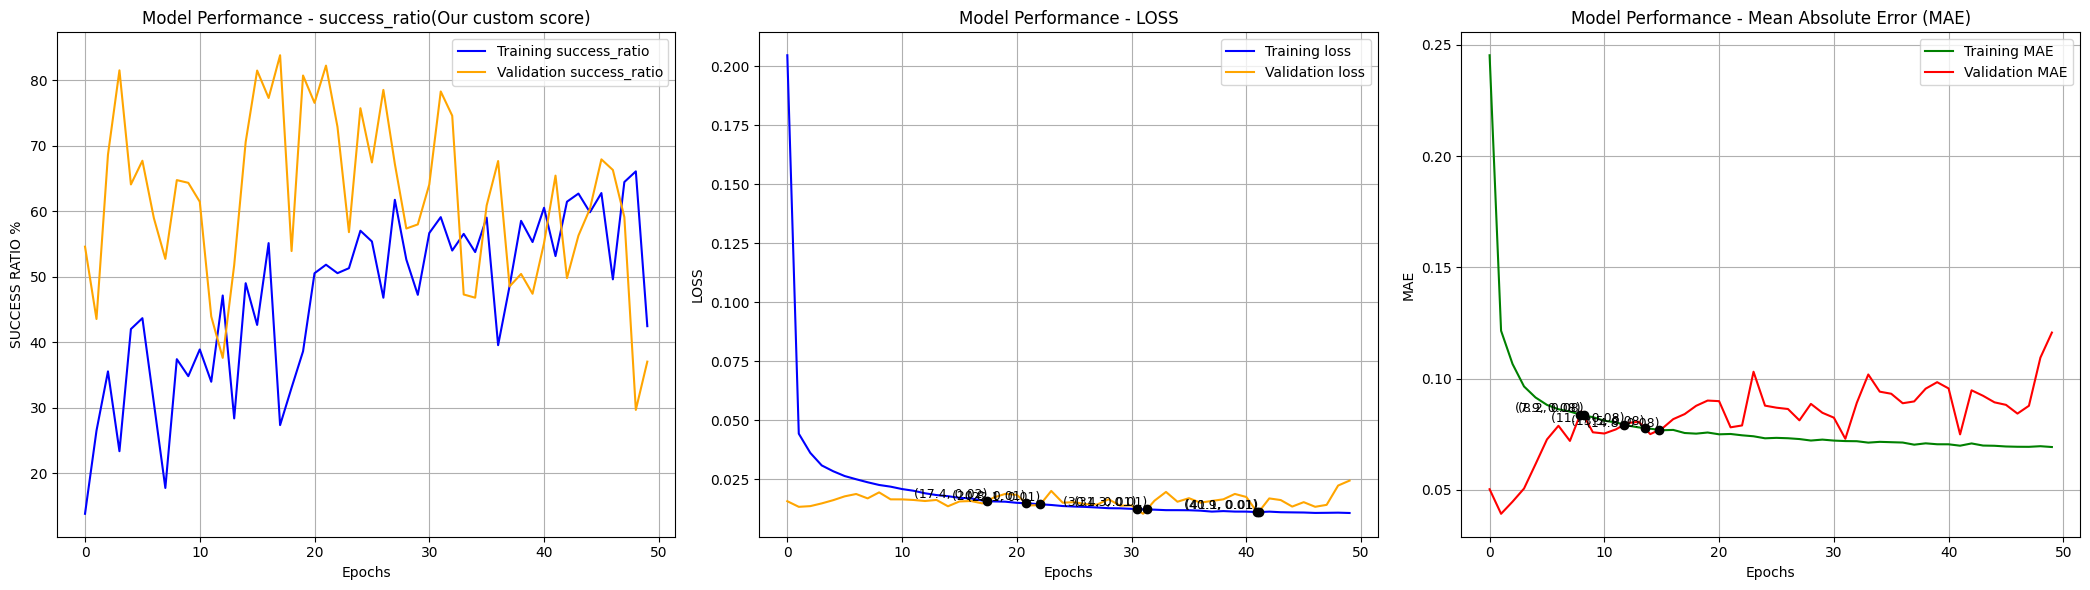

In [11]:
plot_errors(train_loss, val_loss, train_mae, val_mae ,succees,val_success , title_prefix='Model Performance')

In [12]:
print("We can figure out that epoch 8 is good for this model, and will avoid start of overfitting and also good accuracy for validation here.")

We can figure out that epoch 8 is good for this model, and will avoid start of overfitting and also good accuracy for validation here.


In [13]:
#the function should get scaled data
def plot_success_pie( y, ypred):
    # Initialize an array of zeros with the same length as ypred
    success = np.zeros(len(ypred)-1, dtype=int)
    y = y.reshape(-1)
    ypred = ypred.reshape(-1)
    for i in range(1, len(y)):
        if (y[i] > y[i - 1] and ypred[i] > ypred[i - 1]) or (y[i] < y[i - 1] and ypred[i] < ypred[i - 1]):
            success[i-1] = 1
        else:
            success[i-1] = 0
    
    # Count the occurrences of 1s and 0s
    counts = np.bincount(success)
    
    # Labels for the pie chart
    labels = ['Incorrect decision', 'Correct decision']
    
    # Plot pie chart
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
    plt.title('Trend detection')
    print("The chart show us the precentage of the trend (up & down movement) prediction")
    plt.show()




def print_conf_matrix(y,ypred): 
    real_trend =[] #0 represent stock goes down ,1 goes up
    predicted_trend = []
    for i in range(1, len(y)):
        real_trend.append(int(y[i] > y[i - 1]))
        predicted_trend.append(int(ypred[i] > ypred[i - 1]))
    
    cm = confusion_matrix(real_trend, predicted_trend)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
     # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp.plot(cmap='Blues')
    plt.show()



The chart show us the precentage of the trend (up & down movement) prediction


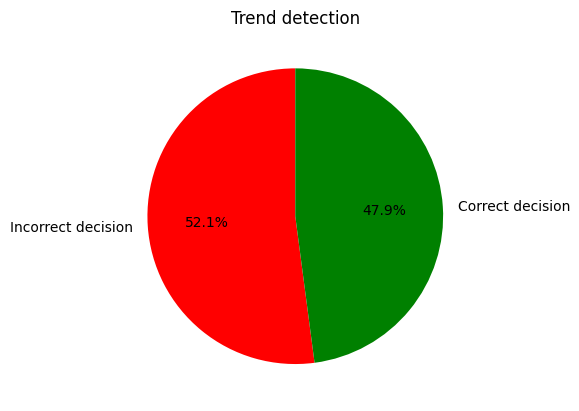

In [14]:
plot_success_pie(y_val_prepared,y_val_predicted)

C:\Users\David\AppData\Local\Temp\ipykernel_19292\2737559405.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  real_trend.append(int(y[i] > y[i - 1]))
C:\Users\David\AppData\Local\Temp\ipykernel_19292\2737559405.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_trend.append(int(ypred[i] > ypred[i - 1]))


Confusion Matrix:
[[4028 4558]
 [4467 4304]]


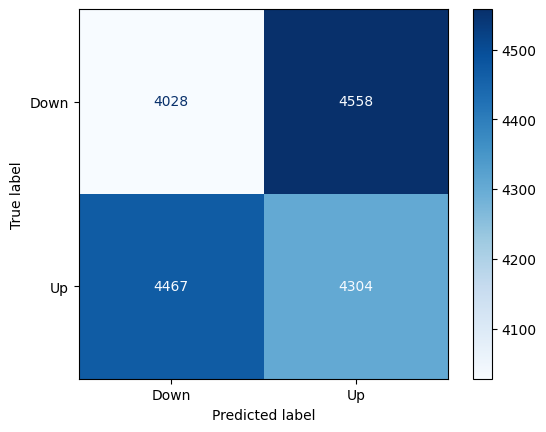

In [15]:
print_conf_matrix(y_val_prepared,y_val_predicted)